<a href="https://colab.research.google.com/github/rb2022/ET5003_SEM1_2021-2/blob/main/ET5003_Kaggle_RobertBarrett_20157347.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_KaggleCompetition

In [ ]:
#@title Current Date
Today = '2021-10-16' #@param {type:"date"}


In [ ]:
#@markdown ---
#@markdown ### Enter your details here:
Team_Number = "5" #@param {type:"string"}
Student_ID&Name = " 20157347 Robert Barrett" #@param {type:"string"}
Student_ID&Name = " 20157347 Robert Barrett" #@param {type:"string"}
Student_ID&Name = " " #@param {type:"string"}
Student_ID&Name = " " #@param {type:"string"}
Student_ID&Name = " " #@param {type:"string"}
#@markdown ---

In [ ]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = Final #@param ["Draft", "Final"] {type:"raw"}
Submission = True #@param {type:"boolean"}

# INTRODUCTION

The following notebook investigates Bayesian Methods on Kaggle House Price data. Bayes Regression, Bayesian Piecewise Regression and Bayesian Neural Networks are used to predict the prices of a test set of properties given a training set of similar properties in the Dublin area.

As with other methods, Exploratory Data Analysis (EDA) and data pre-processing is an important precursor to a successful and performant model and I have applied several methods to ensure the data is prepared for optimal predictions.

Key to this is the use of Natural Language Processing (NLP) to extract additional features from textual descriptions from estate agent advertisements. I applied word count and TF-IDF to extract key features that are seen to have a key impact on buying decisions and the Price paid.

In addition, I have used an XGBoost Feature Importance analysis to understand what features are most likely to contribute most to the predictions. While not a highly accurate method, and only really ueful for generalising on the entire model rather than individual predictions (Masis, 2021; Gianfagna and Di Cecco, 2021), it is a useful approach to selecting appropriate features for training and predictions.

A number of interesting outcomes were seen in the results. It was observed that Bayesian methods did not perform as well as traitional methods, such as XGBoost, in prediction Prices. Further work is required to investigate the hyperparameters of the Bayesian Neural Network, which performed the worst out of all methods, which was surprising.

The following notebook will present code examples and explanations/comments throughout. Once the steps were seen to behave as expected, I created a function of all processing steps. These could equally be embedded in a CV pipeline, but for time and debugging purposes, the function was the best mechanism.

## Imports

In [1]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [4]:
# Scikit-learn is an open source machine learning library 
# that supports supervised and unsupervised learning
# https://scikit-learn.org/stable/
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

In [5]:
# Regular expression operations
#https://docs.python.org/3/library/re.html
import re 

# Natural Language Toolkit
# https://www.nltk.org/install.html
import nltk

# Stemming maps different forms of the same word to a common “stem” 
# https://pypi.org/project/snowballstemmer/
from nltk.stem import SnowballStemmer

# https://www.nltk.org/book/ch02.html
from nltk.corpus import stopwords

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

In [6]:
!pip install gpy

     |████████████████████████████████| 959 kB 5.1 MB/s 
     |████████████████████████████████| 71 kB 7.6 MB/s 
  Created wheel for gpy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2565086 sha256=91693dccb33fd46e75fa410a5c54be300e4a3041d1ad8b9ca6600c0972614db4
  Stored in directory: /root/.cache/pip/wheels/f7/18/28/dd1ce0192a81b71a3b086fd952511d088b21e8359ea496860a
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102565 sha256=9232e22436db44f5e842b457717c8007b18a0e8993696fe23cf9a46161856f46
  Stored in directory: /root/.cache/pip/wheels/c8/95/f5/ce28482da28162e6028c4b3a32c41d147395825b3cd62bc810
Successfully built gpy paramz


In [7]:
import GPy as GPy
import numpy as np
import pylab as pb
import pymc3 as pm
import arviz as az

In [8]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-CS6134/CS6134_SEM1_2021-2/tree/main/Week-5). 

2. Upload the dataset into your folder.



In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
path = '/content/sample_data/'

# Due to formatting issues, I found that explicitly defining features of interest and omitting ones that are problematic was useful

train_file = path+'HousePrice_Train.csv'
test_file = path+'HousePrice_Test.csv'

# Import the data, while excluding 'features' and 'description_block' explicitly on import
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

In [11]:
print(train_data.shape)
print(test_data.shape)

(1638, 14)
(702, 13)


The challenge is to predict the final price of each house.

## Exploratory Data Analysis

#### Let's look at samples of the tabular data and review some basic statistics

In [14]:
# Review samples of training data

train_data.head()

,Index,ID,Location,Num_Bathrooms,Num_Beds,BER_class,Description,Services,Features,Latitude,Longitude,Type,Surface,Price
0,1,12409116,Ongar,2,2,C3,DNG are delighted to present to the market no....,NaN,None,53.396659,-6.438791,apartment,67.00,195000
1,2,12320330,North Strand,1,2,D1,13 Northbrook Terrace is a charming red brick ...,NaN,Bight and Spacious interior\nNumerous original...,53.357129,-6.239779,terraced,95.97,425000
2,3,12405953,Stepaside,3,3,A3,"Welcome to No. 6 Cotter Close, an immaculately...",NaN,Special Features\nLarge rear garden\nGenerous ...,53.266468,-6.222771,semi-detached,107.00,535000
3,4,12202582,Cabinteely,1,3,E1,Welcome to 3 Sycamore Walk!\n\r\nEnjoying a pr...,NaN,Wonderful 3 bed detached bungalow. \nAccom...,53.261600,-6.166738,detached,81.00,499000
4,5,12299336,Lusk,3,4,D1,'Four Seasons' comes to the market as a wonder...,NaN,Detached Property \nDouble Glazed Windows...,53.550731,-6.121415,detached,153.00,510000


In [15]:
# Review samples of test data

test_data.head()

,Index,ID,Location,Num_Bathrooms,Num_Beds,BER_class,Description,Services,Features,Latitude,Longitude,Type,Surface
0,1639,12292473,Milltown,2,2,C2,OMD Estate Agents are delighted to present thi...,"Parking,Oil Fired Central Heating",Designated parking spaces\nPresented in pristi...,53.316269,-6.243391,townhouse,65.0
1,1640,12314667,Glasnevin,2,5,E1,Welcome to Saint Anthony No.214 Glasnevin Aven...,"Parking,Gas Fired Central Heating",Modern Worcester Gas Boiler\nSingle Glazed Win...,53.390769,-6.281936,semi-detached,142.0
2,1641,11699240,Dalkey,1,2,G,"Located in this ever popular road, on grounds ...",NaN,2 BEDROOM DETACHED HOUSE ON 1/5th ACRE\nOIL F...,53.272486,-6.108675,detached,80.0
3,1642,12416984,Raheny,4,4,A2,DNG are delighted to represent the sale of thi...,"Parking,Alarm",Detached House\nSouth Facing Garden\nOff Stree...,53.376932,-6.185334,detached,209.0
4,1643,12383407,Crumlin,2,3,F,A unique opportunity to acquire this red brick...,"Parking,Gas Fired Central Heating,Alarm",Red brick end of terrace property \nC. 108sqm ...,53.327208,-6.308938,end-of-terrace,108.0


In [16]:
# Generate statistcis for numeric training data

train_data.describe()

,Index,ID,Num_Bathrooms,Num_Beds,Latitude,Longitude,Surface,Price
count,1638.000000,1.638000e+03,1638.000000,1638.000000,1638.000000,1638.000000,1638.000000,1.638000e+03
mean,819.500000,1.231930e+07,2.054335,3.043346,53.350473,-6.255086,169.540695,5.547196e+05
std,472.994186,1.447540e+05,1.241259,1.379650,0.076832,0.144430,1791.793934,5.652032e+05
min,1.000000,1.118567e+07,1.000000,1.000000,52.501856,-6.497000,3.400000,1.999500e+04
25%,410.250000,1.228104e+07,1.000000,2.000000,53.294261,-6.309613,73.000000,2.950000e+05
50%,819.500000,1.238055e+07,2.000000,3.000000,53.341386,-6.247780,97.050000,3.950000e+05
75%,1228.750000,1.240548e+07,3.000000,4.000000,53.382031,-6.193982,135.000000,5.950000e+05
max,1638.000000,1.242836e+07,18.000000,27.000000,53.630588,-1.744995,72236.387140,8.900000e+06


#### Initial Analysis of Training Data Statistics
The above table provides a some key information:

1. **counts** indicate no missing values for these numeric features

2. **mean** and **50% Quartile** are the same or close except for "Surface" and "Price" showing an imbalance in the data .. we may need to deal with this.

3. **min** and **max** indicate ranges that need to be scaled

In [17]:
# Check for missing values in Training data 
train_missing = train_data.isnull().sum()*100/len(train_data)
print(train_missing)

Index             0.000000
ID                0.000000
Location          0.000000
Num_Bathrooms     0.000000
Num_Beds          0.000000
BER_class        15.323565
Description       0.000000
Services         64.774115
Features          0.000000
Latitude          0.000000
Longitude         0.000000
Type              0.000000
Surface           0.000000
Price             0.000000
dtype: float64


**Comments** There are two features that have missing values. These are categorical features as they did not appear in above statistics report. High % missing features cannot be remediated and should be removed. We should look at 'BER_class' and see if it is an important feature. If it is, then we should look to see if there is a way to handle the missing values. 

Approach here will be to 

1. Remove 'ID' as it provides no information

2. Remove the feature 'Services' as it has 65% missing data

3. Determine importance of 'BER_class' as a predictor of price. We will use XGBoost and its correspondng "feature_importance" metric.

Reviewing the features for non-uniqueness, there are no features with just one value.

In [18]:
# Let's look at obvious erroneous values - no zero values in the training data

train_data_zeros = (train_data == 0).all()
print(train_data_zeros)

Index            False
ID               False
Location         False
Num_Bathrooms    False
Num_Beds         False
BER_class        False
Description      False
Services         False
Features         False
Latitude         False
Longitude        False
Type             False
Surface          False
Price            False
dtype: bool


There are no features with zeros so we do not have to analyse this further.

In [19]:
# Let's look for obvious coordinates outside Dublin range

outliers = train_data[(train_data.Longitude > -6) | (train_data.Latitude < 53)]

outliers.head()

,Index,ID,Location,Num_Bathrooms,Num_Beds,BER_class,Description,Services,Features,Latitude,Longitude,Type,Surface,Price
355,356,12270559,Clondalkin,1,3,NaN,RAY COOKE AUCTIONEERS take great pleasure in i...,NaN,None,52.501856,-1.744995,semi-detached,79.0,199000


This location has coordinates for a UK address and should be removed.

In [12]:
# Remove location in UK
df_train = train_data.drop(train_data[(train_data.Longitude > -6) | (train_data.Latitude < 53)].index)

In [13]:
# Drop unimportant features

df_train.drop(['ID', 'Services'], axis=1, inplace=True)

In [14]:
# Let's deal with categorical data

# Feature map 'locations': combine locations in training and test datasets and extract unique list of these
locations = np.hstack((train_data['Location'], test_data['Location']))
unique_loc = np.unique(locations)
unique_loc_index=[]

# Create a dictionary lookup: create an incremental index for each location, i.e. 1, 2, 3, ... n
i = [i+1 for i in range(len(unique_loc))]
unique_areas_index = dict(zip(unique_loc, i))

# Replace area name with the index from the 'unique_areas_index' dictionary 
df_train_1 = df_train.replace({'Location': unique_areas_index})

# Feature map 'BER_class': same approach as for Locations above
ber_stack = np.hstack((train_data['BER_class'], test_data['BER_class'])) # get all BER Classes from Train and Test datasets to ensure we have all classes in each set.
ber_class = [c for c in ber_stack if not(pd.isna(c)) == True] # remove NaN from feature map list
unique_ber = np.unique(ber_class)
unique_ber_index=[]

# Create a dictionary lookup
i = [i+1 for i in range(len(unique_ber))]
unique_ber_index = dict(zip(unique_ber, i))

# Replace BER_class with the index from the 'unique_ber_index' dictionary 
df_train_2 = df_train_1.replace({'BER_class': unique_ber_index})

# One-hot Encode 'Type'
df_train_2 = pd.get_dummies(df_train_2, columns=['Type'])

df_train = df_train_2.copy()

# Take a copy of the Location and BER_class column before scaling - this will be used during imputing for NaNs later
loc_ber_train_values = df_train[['Location', 'BER_class']].copy()


We will now look at the feature distributions and outliers.

In [15]:
df_train.columns

Index(['Index', 'Location', 'Num_Bathrooms', 'Num_Beds', 'BER_class',
       'Description', 'Features', 'Latitude', 'Longitude', 'Surface', 'Price',
       'Type_apartment', 'Type_bungalow', 'Type_detached', 'Type_duplex',
       'Type_end-of-terrace', 'Type_semi-detached', 'Type_site', 'Type_studio',
       'Type_terraced', 'Type_townhouse'],
      dtype='object')

We will look at these key features:

'Location', 'Num_Bathrooms', 'Num_Beds', 'BER_class', 'Latitude', 'Longitude', 'Surface', 'Price'

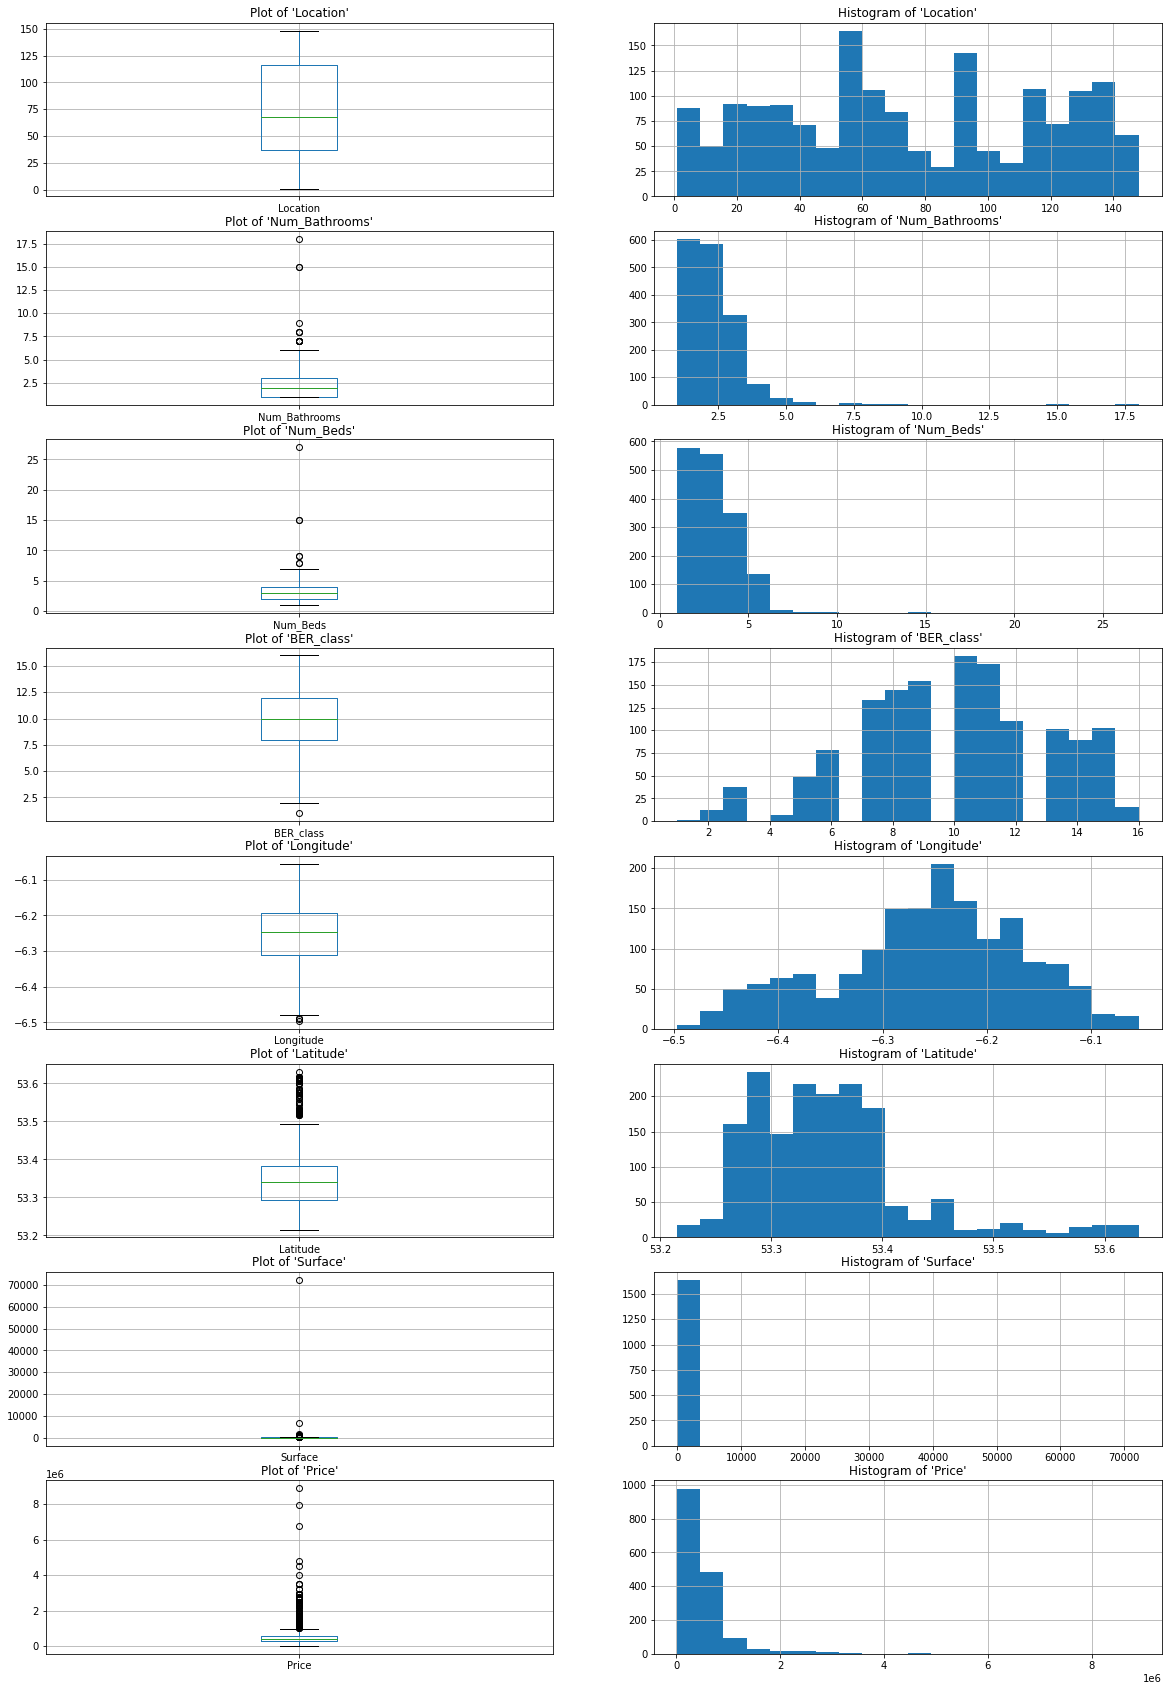

In [16]:
# First we will look at the distribution of key predictor features

fig = plt.figure(figsize=(20,30))

ax1 = fig.add_subplot(8, 2, 1)
ax1.set_title("Plot of 'Location'")
df_train.boxplot(column=['Location'])

ax2 = fig.add_subplot(8, 2, 2)
ax2.set_title("Histogram of 'Location'")
df_train['Location'].hist(bins=20)

ax3 = fig.add_subplot(8, 2, 3)
ax3.set_title("Plot of 'Num_Bathrooms'")
df_train.boxplot(column=['Num_Bathrooms'])

ax4 = fig.add_subplot(8, 2, 4)
ax4.set_title("Histogram of 'Num_Bathrooms'")
df_train['Num_Bathrooms'].hist(bins=20)

ax5 = fig.add_subplot(8, 2, 5)
ax5.set_title("Plot of 'Num_Beds'")
df_train.boxplot(column=['Num_Beds'])

ax6 = fig.add_subplot(8, 2, 6)
ax6.set_title("Histogram of 'Num_Beds'")
df_train['Num_Beds'].hist(bins=20)

ax7 = fig.add_subplot(8, 2, 7)
ax7.set_title("Plot of 'BER_class'")
df_train.boxplot(column=['BER_class'])

ax8 = fig.add_subplot(8, 2, 8)
ax8.set_title("Histogram of 'BER_class'")
df_train['BER_class'].hist(bins=20)

ax9 = fig.add_subplot(8, 2, 9)
ax9.set_title("Plot of 'Longitude'")
df_train.boxplot(column=['Longitude'])

ax10 = fig.add_subplot(8, 2, 10)
ax10.set_title("Histogram of 'Longitude'")
df_train['Longitude'].hist(bins=20)

ax11 = fig.add_subplot(8, 2, 11)
ax11.set_title("Plot of 'Latitude'")
df_train.boxplot(column=['Latitude'])

ax12 = fig.add_subplot(8, 2, 12)
ax12.set_title("Histogram of 'Latitude'")
df_train['Latitude'].hist(bins=20)

ax13 = fig.add_subplot(8, 2, 13)
ax13.set_title("Plot of 'Surface'")
df_train.boxplot(column=['Surface'])

ax14 = fig.add_subplot(8, 2, 14)
ax14.set_title("Histogram of 'Surface'")
df_train['Surface'].hist(bins=20)

ax15 = fig.add_subplot(8, 2, 15)
ax15.set_title("Plot of 'Price'")
df_train.boxplot(column=['Price'])

ax16 = fig.add_subplot(8, 2, 16)
ax16.set_title("Histogram of 'Price'")
df_train['Price'].hist(bins=20)

There is an outlier on 'Surface' that needs to be investigated

In [ ]:
df_train[(df_train.Surface > 2000)]

,Index,Location,Num_Bathrooms,Num_Beds,BER_class,Description,Features,Latitude,Longitude,Surface,Price,Type_apartment,Type_bungalow,Type_detached,Type_duplex,Type_end-of-terrace,Type_semi-detached,Type_site,Type_studio,Type_terraced,Type_townhouse
506,507,138,1,4,12.0,Thornton Park is a superb modern equestrian ce...,None,53.474502,-6.343483,72236.38714,1100000,0,1,0,0,0,0,0,0,0,0
1115,1116,19,1,2,13.0,Baxter Real Estate are delighted to present to...,Short drive to the N3 and M50 .\nSuitable for ...,53.386540,-6.377356,6705.00000,425000,0,1,0,0,0,0,0,0,0,0


There is only two values in the range greater than 2,000. Decision to remove them seems valid, although we wil be limited to the area size <= 2,000

In [17]:
df_train = df_train.drop(df_train[df_train.Surface > 2000].index) # remove these properties with large areas/outliers

In [18]:
# Apply scalers to data to resolve distribution and outlier issues
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
standardscaler = StandardScaler()

# Not a normal distribution so just scale with MinMax [0, 1]
df_train[['Location']] = minmax.fit_transform(df_train[['Location']])

# Deal with outliers with a Log Transform - later we will use Standard Scaler as well on some feature
df_train['Num_Bathrooms'] = np.log(df_train['Num_Bathrooms'])

df_train['Num_Beds'] = np.log(df_train['Num_Beds'])

df_train['Latitude'] = np.log(df_train['Latitude'])

df_train['Surface'] = np.log(df_train['Surface'])

df_train['Price'] = np.log(df_train['Price'])

# Standard scaler for normal distributions
df_train[['BER_class', 'Longitude', 'Latitude', 'Surface', 'Price']] = standardscaler.fit_transform(df_train[['BER_class', 'Longitude', 'Latitude', 'Surface', 'Price']])


Do the same scaling to the Test Data

In [19]:
# Check for missing values in Training data - calculate % misisng values
test_missing = test_data.isnull().sum()*100/len(test_data)
print(test_missing)

Index             0.000000
ID                0.000000
Location          0.000000
Num_Bathrooms     0.000000
Num_Beds          0.000000
BER_class        15.384615
Description       0.000000
Services         64.957265
Features          0.000000
Latitude          0.000000
Longitude         0.000000
Type              0.000000
Surface           0.000000
dtype: float64


In [20]:
# Drop unimportant features

test_data.drop(['ID', 'Services'], axis=1, inplace=True)


In [21]:
df_test = test_data.copy()

In [22]:
# Let's deal with categorical data for Test Dataset

# Replace area name with the index from the 'unique_areas_index' dictionary 
df_test_1 = df_test.replace({'Location': unique_areas_index})

# Replace BER_class with the index from the 'unique_ber_index' dictionary 
df_test_2 = df_test_1.replace({'BER_class': unique_ber_index})

# One-hot Encode 'Type'
df_test_2 = pd.get_dummies(df_test_2, columns=['Type'])

df_test = df_test_2.copy()

# Take a copy of the Location and BER_class column before scaling - this will be used during imputing for NaNs later
loc_ber_test_values = df_test[['Location', 'BER_class']].copy()

# Apply same scalers as for Training dataset
df_test[['Location']] = minmax.fit_transform(df_test[['Location']])

df_test['Num_Bathrooms'] = np.log(df_test['Num_Bathrooms'])

df_test['Num_Beds'] = np.log(df_test['Num_Beds'])

df_test['Latitude'] = np.log(df_test['Latitude'])

df_test['Surface'] = np.log(df_test['Surface'])

# Standard scaler for normal distributions
df_test[['BER_class', 'Longitude', 'Latitude', 'Surface']] = standardscaler.fit_transform(df_test[['BER_class', 'Longitude', 'Latitude', 'Surface']])


Now let's look at 'BER_class' and see how important it is for predicting price.
The following approach uses XGBoost Regression algorithm which has some powerful built in functions for Feature Importance.

In [23]:
# Let's take a closer look at 'BER_class' using feature importance on all data set
# We will look at the feature Importance of 'BER_class' with empty features removed from the dataset 
# and left in to see check the impact also for imputation.

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

def xgb_model(X, y, msg):

  xgb_model = xgb.XGBRegressor(max_depth=7, learning_rate = 0.6, n_jobs=4, objective = 'reg:squarederror', random_state=10, n_estimators=50).fit(X, y)

  y_xgb_pred = xgb_model.predict(X)

  RMSE_xgb = mean_squared_error(y, y_xgb_pred, squared=False)

  r2_xgb = r2_score(y, y_xgb_pred)

  print(msg)

  print("RMSE_score: %.4f   R2_score: %.4f" %(RMSE_xgb, r2_xgb))

  return xgb_model, RMSE_xgb, r2_xgb

In [24]:
# Let's look at the Feature Importance with all BER_class values equal to NULL removed
# We will also remove large text features for now.

features = ['Location', 'Num_Bathrooms', 'Num_Beds', 'BER_class',
                        'Latitude', 'Longitude', 'Surface', 'Type_apartment', 
                        'Type_bungalow', 'Type_detached', 'Type_duplex',
                        'Type_end-of-terrace', 'Type_semi-detached', 'Type_site', 'Type_studio',
                        'Type_terraced', 'Type_townhouse', 'Price']

df_train_xgb = df_train[features]
X_train_xgb = df_train_xgb.iloc[:,0:-1].values 
y_train_xgb = df_train_xgb.iloc[:,-1].values.reshape(-1,1)  

df_train_xgb_partial = df_train_xgb.dropna(how='all', subset=['BER_class'])
X_train_xgb_partial = df_train_xgb_partial.iloc[:,0:-1].values
y_train_xgb_partial = df_train_xgb_partial.iloc[:,-1].values.reshape(-1,1) 

# Call XGBoost Model for each dataset

Model_Full, RMSE_xgb_train_full, r2_xgb_train_full = xgb_model(X_train_xgb, y_train_xgb, "Performance Evaluation for Full Training Set")

Model_Partial, RMSE_xgb_train_partial, r2_xgb_train_partial = xgb_model(X_train_xgb_partial, y_train_xgb_partial, "Performance Evaluation for NaNs Removed")



Performance Evaluation for Full Training Set
RMSE_score: 0.0332   R2_score: 0.9989
Performance Evaluation for NaNs Removed
RMSE_score: 0.0230   R2_score: 0.9994


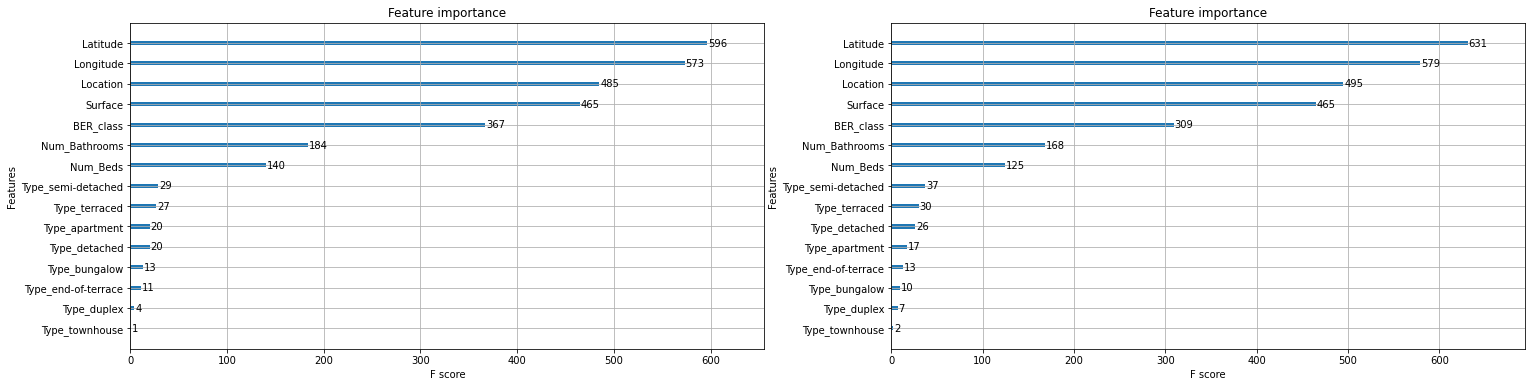

In [25]:
# Let's plot the Feature Importance for each of these solutions

import seaborn as sn

fig = plt.figure(figsize=(25,6))

Model_Full.get_booster().feature_names = features[:-1]
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Plot of Feature Importance for Full Model")
xgb.plot_importance(Model_Full, max_num_features= 17, ax=ax1, importance_type="weight")

Model_Partial.get_booster().feature_names = features[:-1]
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Plot of Feature Importance for Model with NaNs removed.")
xgb.plot_importance(Model_Partial, max_num_features= 17, ax=ax2, importance_type="weight")

plt.show()


**Analysis of Plots** It can be seen from the above plots of Training Dataset with NaNs removed (plot on right) and with NaNs left in (plot on left) that both plots confirm the importance of BER_class. XGBoost handles NaN values by default but we cannot expect that all models wil do so. We will keep the BER_class and compute imputed values for missing data.

Note also that both models agree on the overall importance of features. The Top 7 Features have a greater influence on model performance. It seems that property 'Type' is not so important.

For this exercise, I will concentrate on the Top 7 key features and remove the 'Type'

#### Imputing BER_class value: replace NaNs with average BER by location

In [26]:
# First we will determine the average BER_class for each Location.
# This approach was taken because many locations have a mix of BER ratings (determined from analysis)
# but are, in general, either new development areas or mature development areas and as such 
# are likely to have ratings within a range based on maturity of the location as a whole.

# Determine the average BER_class rating by location
feat = ['Location', 'BER_class']
train_feat = df_train_2[feat]
test_feat =  df_test_2[feat]
train_test_stack = pd.concat([train_feat, test_feat])

average_vals = train_test_stack.groupby(['Location'], dropna=True)['BER_class'].mean().round()


**Comment** The code above creates a lookup of Average BER_class by Location. However, this is not a perfect lookup as there are several locations in the combined Training and Test datasets that have only one property in certain locations and these properties have a NaN value for BER_class. This means that the lookup will not be able to replace these NaNs with an average. Tests have shown that the effect is limited and the BER_class is improved from 15.4% missing values to 0.1% missing values. 

In [27]:
# Look for NaNs and replace them with the average for the given location
import math

def impute_ber(data):
  for index, row in data.iterrows():
    if math.isnan(row['BER_class']): 
      loc = row['Location']
      lookup_ber = average_vals.loc[loc]
      data.loc[index, "BER_class"] = lookup_ber
  return data

In [28]:
# Impute BER_class on training data
ber_tr_values = impute_ber(loc_ber_train_values)

# Impute BER_class on test data
ber_ts_values = impute_ber(loc_ber_test_values)

# There are still a very small number (2 in both training and test datsets) of NaNs due to single properties in locations that have NaNs and therefore could not be averaged
# We will apply an average over the entire feature for BER_class to populate these
ber_tr_values['BER_class'].fillna((ber_tr_values['BER_class'].mean()), inplace=True)
ber_ts_values['BER_class'].fillna((ber_ts_values['BER_class'].mean()), inplace=True)

# We can apply the standard scaler to each of the training and test set BER_class features
ber_tr_values[['BER_class']] = standardscaler.fit_transform(ber_tr_values[['BER_class']])
ber_ts_values[['BER_class']] = standardscaler.fit_transform(ber_ts_values[['BER_class']])

# Then we insert these columns back into the df_train and df_test datasets
df_train['BER_class'] = ber_tr_values['BER_class']
df_test['BER_class'] = ber_ts_values['BER_class']

In [29]:
# Let's test for any performance changes with the XGBoost Model

# Remove 'Type' from dataset as it does not appear to be too important
features = ['Location', 'Num_Bathrooms', 'Num_Beds', 'BER_class',
                        'Latitude', 'Longitude', 'Surface','Price']

df_train_xgb = df_train[features]
X_train_xgb = df_train_xgb.iloc[:,0:-1].values 
y_train_xgb = df_train_xgb.iloc[:,-1].values.reshape(-1,1)  

# Call XGBoost Model for each dataset
Model_Full, RMSE_xgb_train_full, r2_xgb_train_full = xgb_model(X_train_xgb, y_train_xgb, "Performance Evaluation for Full Training Set")


Performance Evaluation for Full Training Set
RMSE_score: 0.0410   R2_score: 0.9983


**Comment** The performance of the XGBoost Model has not shown much improvement with the imputing of missing BER_values. However, that is expected as XGBoost handles missing values by default. We expect to see no great impact on the model, but no deterioration.

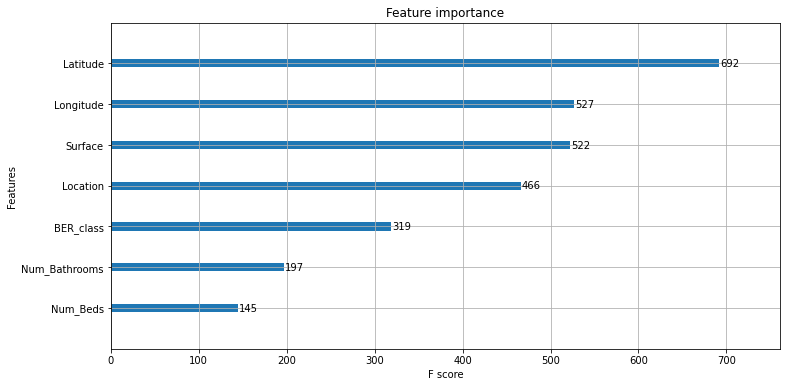

In [30]:
# Plot the Feature Importance to see what the impact of imputing BER_class has been
fig, ax = plt.subplots(figsize=(12, 6))

Model_Full.get_booster().feature_names = features[:-1]
xgb.plot_importance(Model_Full, max_num_features= 7, ax=ax, importance_type="weight")
plt.show()

**Comment** As mentioned above, we expect to see no great change from in either BER_class feature importance. Key here is the model performs well with the newly processed data and that is confirmed. We want to process the data to perform well with models that do not handle missing data well and that is what we have done here.

The training and test datasets have been fully processed by removing unnecessary columns, removing erroneous records, scaling and imputing values to provide complete datasets ready for further processing.

**Comment** key to note here is the scales on all features are within similar ranges and not with large differences.

# NATURAL LANGUAGE PROCESSING

Natural language processing ([NLP](https://en.wikipedia.org/wiki/Natural_language_processing)) is a subfield of linguistics, computer science, and artificial intelligence.

* NLP concerned with the interactions between computers and human language.
* In particular how to program computers to process and analyze large amounts of natural language data. 
* The goal is a computer capable of "understanding" the contents of documents.
* Including the contextual nuances of the language within them. 
* The technology can then accurately extract information and insights contained in the documents.
* As well as categorize and organize the documents themselves. 

For this section, we will process the two textual features using NLP techniqus. The two textual features are:

1. Description

2. Features

We are looking to see if these features have an impact on price. There maybe some words or phrases (bi- or tri-grams) that may influence the Price paid for the propertes. This is interesting because these are typically used by sellers or estate agents to describe the property for sale. The use of descriptions like this, as well as more detail on features of the property, are likely to influence buyers, so we will test this.

### Approach to using NLP to increase the performance of the datasets
There are many options available to using NLP to process text data. For the current exercise, I will look at using NLP to provide additional features that may enhance the results and increase performance of the prediction models.

The approach will take the follow steps
1. Process 'Description' and 'Features' features to extract relevant words or phrases (n-grams). **Note**: It has been observed that these features, especially 'Description' can have similar text content. An initial review has also found descriptions of property features in the 'Description' field and "None" in the 'Features' field. This will be mitigated by combining these textual fields for processing.

2. Combine 'Description' and 'Features' fields and process by removing extraneous content such as numbers, punctuation, stopwords, etc and then Stemming, Lemmatizing, etc. to produce clean textual content.

3. Apply TF-IDF to extract the most important words and phrases across the textual corpus.

4. Order and select the top X number of words and phrases and create new features from them on the datasets, i.e. 'has_Parking', 'has_Garden', 'local_Amenities', etc.

5. Process each property record in both Training and Test datasets to update these features with [0, 1] if any of the words or phrases are present in the text of the record/sample.

6. This will provide additional features to train on - I will train on a full set of features on both Bayes Regression Model and Bayes Neural Network.

7. I will also see if these features change the Feature Importance selected by XGBoost.

8. Overall performance improvement will be evaluated across models with/without these new features.

## Word Counting in Property Corpus

In [31]:
# Set up the various components of the NLP processing code

from nltk.tokenize import word_tokenize  
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
nltk.download('punkt')
nltk.download('wordnet')
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [32]:
# Define a text preprocessing function

def nlp_preprocess(text):
 
  text = text.lower() # set all text to lower case

  string = re.sub('[^a-zA-Z]', ' ', text) # extract only words from text

  text = " ".join(string.split()) # split text into words

  shortword = re.compile(r'\W*\b\w{1,2}\b') # remove single or double letter words
  text = (shortword.sub('', text))

  # 1. Tokenization
  NLP_token = word_tokenize(text) # Tokenise the words

  # 3. Lemmatization
  WL = WordNetLemmatizer()
  NLP_lemma = []
  for word in NLP_token:
  #for word in NLP_stem:
      NLP_lemma.append(WL.lemmatize(word))
  
  # 4. Stopword   
  FS = []  
  NLP_stop = set(stopwords.words("english"))
  for w in NLP_lemma:  
      if w not in NLP_stop:  
        FS.append(w)
  
  # 5. Punctuation  
  punctuations = "?:!.,;"
  for word in FS:
      if word in punctuations:
          FS.remove(word)
             
  return FS

In [33]:
# Function to count words in text corpi

def count_words(text):
  for word in text:
    if word not in list(word_counts.keys()): word_counts.update({word:1})
    else: word_counts[word] += 1
  return word_counts

In [34]:
# Firstly, let's add back the "Description" and "Features" columns to the df_train and df_test datsets

df_train['Desc_Feat'] = train_data['Description'] + ' ' + train_data['Features']

df_test['Desc_Feat'] = train_data['Description'] +' ' + train_data['Features']


In [35]:
# Generate the list of words sorted by count of word occurrences
word_counts={}

n = df_train.shape[0]
for p in range(n):
  text= nlp_preprocess((df_train.iloc[p]['Desc_Feat']))
  count_words(text)

sorted_words = dict(sorted(word_counts.items(), key=lambda x: x[1], reverse=True))

In [36]:
# Create a DataFrame from the sorted list of words by word occurrences
# Select just top 120 values

words = list(sorted_words.keys())[0:120]
count = list(sorted_words.values())[0:120]

df_wdcount=pd.DataFrame(words, columns=['Words'])
df_wdcount['Counts'] = count

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119]), <a list of 120 Text major ticklabel objects>)

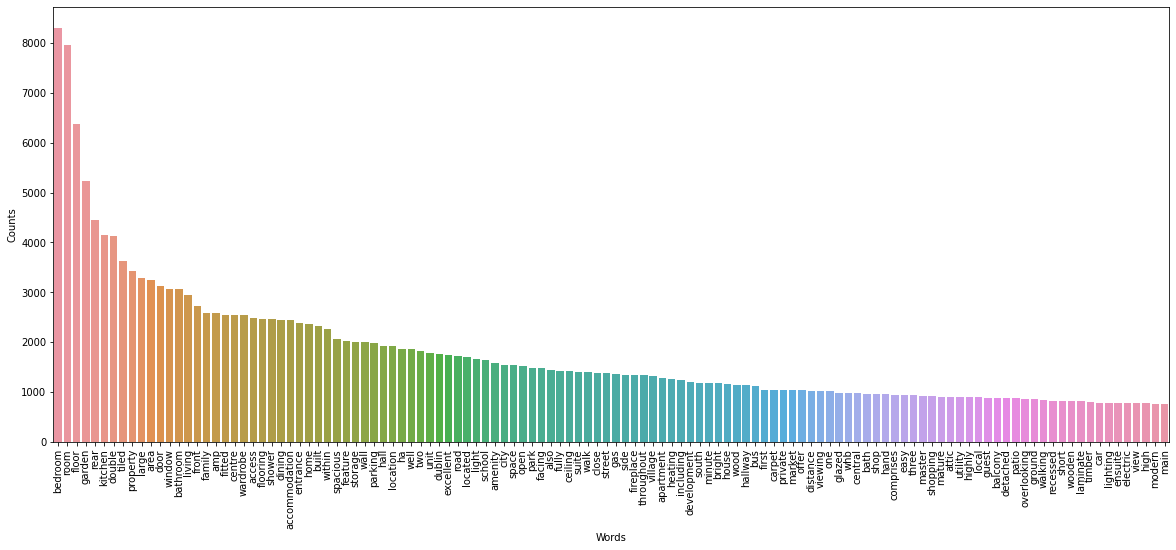

In [37]:
# Plot the list of words by word accurences acorss all the prperty records

plt.figure(figsize=(20, 8))
ax = sn.barplot(x='Words', y='Counts', data=df_wdcount, order=df_wdcount.sort_values('Counts', ascending=False).Words)
plt.xticks(rotation=90)

### Word Occurrence Plot
**Analysis** This plot of Word Occurrence in the corpus of text provides us with an view on recurring words in the description+feature text describing the properties. Recurring descriptive words are important as they are used by estate agents to differentiate properties and attract buyers. Many word are typically used by estate agents and they have a lexicon that they use for advertisements. 

However, the word occurrence, while important, does not tell the whole story. Recurring words may not differentiate properties in a large list of properties. Very common words may not attract attention to buy or have an impact on price, which is what we are predicting here. To augment our analysis, we will also look at TF-IDF to identify important words within the property descriptions.

## Term Frequency-Inverse Document Frequency (TF-IDF) in Property Corpus

In [38]:
df_train.columns

Index(['Index', 'Location', 'Num_Bathrooms', 'Num_Beds', 'BER_class',
       'Description', 'Features', 'Latitude', 'Longitude', 'Surface', 'Price',
       'Type_apartment', 'Type_bungalow', 'Type_detached', 'Type_duplex',
       'Type_end-of-terrace', 'Type_semi-detached', 'Type_site', 'Type_studio',
       'Type_terraced', 'Type_townhouse', 'Desc_Feat'],
      dtype='object')

In [39]:
# Test out TF-IDF on the corpus of Description+Features
# Preprocess the data first ... although for TF-IDF it would push common words down the list anyway, but for simplicity we remove them

corpus = []
n = df_train.shape[0]
for p in range(n):
  text = nlp_preprocess((df_train.iloc[p]['Desc_Feat']))
  corpus.append(" ".join(text))

In [40]:
# Apply TF-IDF to the corpus of text across all property records
# This approach will provide us with another list, but this time rather than just calculating common words
# we will calculate using TF-IDF hwo important words are to the corpus of documents

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

tfidfTransform = TfidfTransformer(use_idf=True)
CV = CountVectorizer()
word_count = CV.fit_transform(corpus)
tf_idf = tfidfTransform.fit_transform(word_count)
df = pd.DataFrame(tf_idf[0].T.todense(), index=CV.get_feature_names(), columns=['tfidf'])
df = df.sort_values('tfidf', ascending=False)
print(df.head(120))

                  tfidf
extensively    0.333659
chipping       0.312013
row            0.283394
bedroom        0.168313
apartment      0.159009
...                 ...
school         0.034877
home           0.034100
location       0.032385
accommodation  0.027935
peninsula      0.000000

[120 rows x 1 columns]


In [41]:
# Reset the index of the dataframe and rename the index to make it easier to plot.

df.reset_index(inplace=True)
df_150=df.loc[1:150] # select 150 words from the dataframe
df_150_words = df_150.rename(columns={"index":"words"})

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149]),
 <a list of 150 Text major ticklabel objects>)

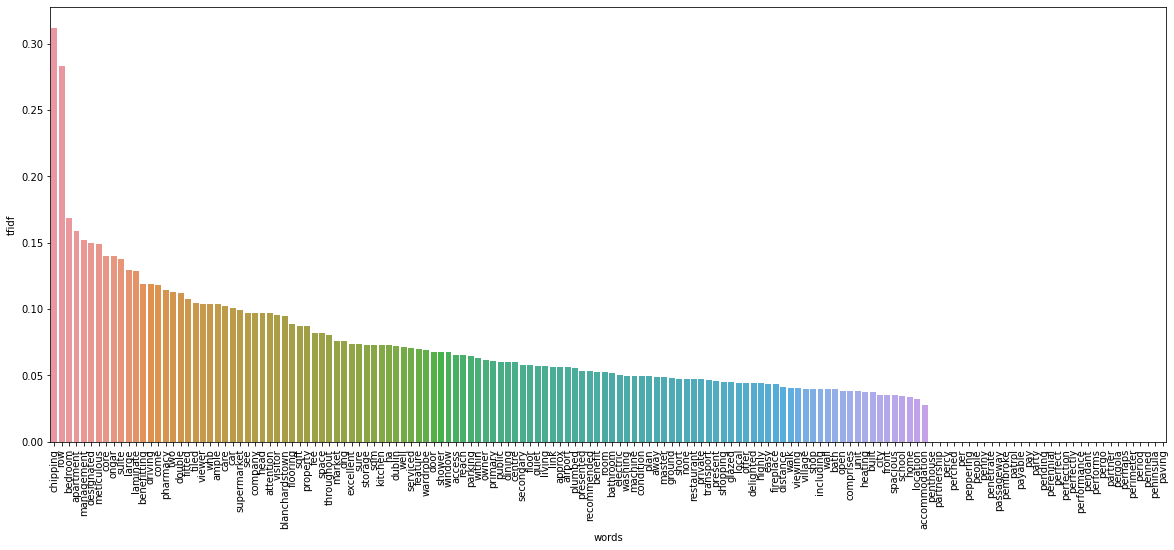

In [42]:
# Plot ordered list of words by TF-IDF score

plt.figure(figsize=(20, 8))
ax = sn.barplot(x='words', y='tfidf', data=df_150_words, order=df_150_words.sort_values('tfidf', ascending=False).words)
plt.xticks(rotation=90)

### Term Frequency - Inverse Document Frequency (TF-IDF) Plot
**Analysis** This plot differs from the pure word count plot above. It provides a visual of the words that are most important to the corpus of data. You can see the words order by *how important they are* with words that are very common, i.e. recur very frequenetly in the property descriptions, set to '0' - this can be seen by the suddent drop after the word "accomodation".

A good description of how TF-IDF works can be found in the text by Silge and Robinson (2021) and Chaudhary (2020).


In [ ]:
# Prints word position for analysis below

print (df_150_words[df_150_words['words'] == "amenity"])

print (df_wdcount[df_wdcount['Words'] == "amenity"])

Empty DataFrame
Columns: [words, tfidf]
Index: []
      Words  Counts
47  amenity    1577


### How do we create new features from this information?
With the Word Occurrence and TF-IDF information we can now apply an heuristic approach to determine the new features.
Neither plots provides us with all the information but given an understanding of what is important for prospective home buyers (or investors as the case may be), we can say:

1. Having a garden is an important feature of a house but not an apartment. The word 'garden' appears a lot (high on Word Occurrence and low (< 7000) on TF-IDF). Given this we can assume that 'garden' is not a major differentiator in general but it is an important consideration to *generalise* our model

2. Parking appears quite high in both word occurrence and TF-IDF score. It is clearly important for both house and apartment buyers. We will include this as one of our features

3. School also appears on both plots: word occurrence (46) and TF-IDF (115). For families we know that this is important. Families live in both houses and apartments and it can be a deciding factor

4. Public Transport appears as "transport" in TF-IDF and as "bus" in word count. Based on knowledge that public transport is important in Dublin, we can take these values as important features.

5. Local Amenities appear in both lists of words as "amentity", "restaurant", "pharmacy", "supermarket. These are key both from the position on both plots and heuristic domain knowledge.

With these findings, we can now search the individual words in each property record looking for these words and setting [0] if it does not occur and [1] if it does for the following nw features:

1. has_Garden
2. has_Parking
3. local_School (close to schools to include "school", "secondary", "primary")
4. local_Transport (to include "transport", "bus")
5. local_Amenities (to include "amenity", "shop", "shopping", "restaurant", "supermarket")


### Create new features from above rules

In [43]:
# Reload the data to ensure we are working with clean datasets

path = '/content/sample_data/'

# Due to formatting issues, I found that explicitly defining features of interest and omitting ones that are problematic was useful

train_file = path+'HousePrice_Train.csv'
test_file = path+'HousePrice_Test.csv'

# Import the data, while excluding 'features' and 'description_block' explicitly on import
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

In [44]:
# Create new features in training and test dataframes
# Go back to original datasets: we will want to split them for performance testing on training and validation sets

df_train = train_data.join(pd.DataFrame(
    {
        'has_Garden': 0,
        'has_Parking': 0,
        'local_School': 0,
        'local_Transport': 0,
        'local_Amenities': 0
    }, index=train_data.index
))

In [45]:
# Combine 'Description' and 'Features'

df_train['Desc_Feat'] = df_train['Description'] + ' ' + df_train['Features']

In [46]:
# check if words are in a text

def words_in_text(list, text):
  return set(list).intersection(text)

In [47]:
# Process the text descriptions in the new 'Desc_Feat' column for each property

_Garden = ["garden"]
_Parking = ["parking"]
_localSchool = ["school", "primary school", "secondary school"]
_localTransport = ["transport", "bus"]
_localAmenities = ["amenity", "shop", "shopping", "restaurant", "supermarket", "pharmacy"]

for index, row in df_train.iterrows():
  descfeat = []
  text = nlp_preprocess((df_train.iloc[index]['Desc_Feat']))
  descfeat.append(" ".join(text))

  # check for key keywords to set the new features
  if words_in_text(_Garden, text): df_train.loc[index, "has_Garden"] = 1
  if words_in_text(_Parking, text): df_train.loc[index, "has_Parking"] = 1
  if words_in_text(_localSchool, text): df_train.loc[index, "local_School"] = 1
  if words_in_text(_localTransport, text): df_train.loc[index, "local_Transport"] = 1
  if words_in_text(_localAmenities, text): df_train.loc[index, "local_Amenities"] = 1

In [48]:
# Drop these columns from the datasets; they are no longer needed

df_train.drop(columns=['Description', 'Features', 'Desc_Feat'], inplace=True)

In [49]:
df_train.head()

,Index,ID,Location,Num_Bathrooms,Num_Beds,BER_class,Services,Latitude,Longitude,Type,Surface,Price,has_Garden,has_Parking,local_School,local_Transport,local_Amenities
0,1,12409116,Ongar,2,2,C3,NaN,53.396659,-6.438791,apartment,67.00,195000,0,1,1,1,1
1,2,12320330,North Strand,1,2,D1,NaN,53.357129,-6.239779,terraced,95.97,425000,1,0,1,0,1
2,3,12405953,Stepaside,3,3,A3,NaN,53.266468,-6.222771,semi-detached,107.00,535000,1,1,1,1,1
3,4,12202582,Cabinteely,1,3,E1,NaN,53.261600,-6.166738,detached,81.00,499000,1,1,1,1,1
4,5,12299336,Lusk,3,4,D1,NaN,53.550731,-6.121415,detached,153.00,510000,1,0,1,0,0


### Comments on New Features for datasets
Now we have added five new features to the property datasets. Before we take the next step to train and test ML Models, I will quickly take a look to see if these features have impacted Feature Importance order.

### Pipeline Function
Firstly we create pipeline functions to encapsulate the pre-processing steps before modelling.

In [50]:
# Create a processing pipeline as a function

def drop_outliers(dataset):

  # Remove outliers for location that is not in Dublin
  df_dataset = dataset.drop(dataset[(dataset.Longitude > -6) | (dataset.Latitude < 53)].index)

  # Remove Surface values over 2000.
  df_dataset = df_dataset.drop(df_dataset[df_dataset.Surface > 2000].index)

  return df_dataset

def process_dataset(dataset, exclude="None"):

  # Drop unimportant features
  dataset.drop(['ID', 'Index', 'Services'], axis=1, inplace=True)

  df_dataset = dataset.copy()

  # Replace Locations with index value from 'unique_areas_index' lookup
  df_dataset_1 = df_dataset.replace({'Location': unique_areas_index})

  # Replace BER_class with index value from 'unique_ber_index'
  df_dataset_2 = df_dataset_1.replace({'BER_class': unique_ber_index})

  # One-hot-encode 'Type
  if exclude == "None": 
    df_dataset_2 = pd.get_dummies(df_dataset_2, columns=['Type'])
  else: df_dataset_2.drop(columns=['Type'], inplace=True)

  df_dataset = df_dataset_2.copy()

  # Take a copy of the Location and BER_class before applying further scaling

  loc_ber_dataset_values = df_dataset[['Location', 'BER_class']].copy()

  # Apply scalers to features
  # Not a normal distribution so just scale with MinMax [0, 1]

  minmax=MinMaxScaler()
  standardscaler = StandardScaler()

  df_dataset[['Location']] = minmax.fit_transform(df_dataset[['Location']])

  # Deal with outliers with a Log Transform - later we will use Standard Scaler as well on some feature
  df_dataset['Num_Bathrooms'] = np.log(df_dataset['Num_Bathrooms'].apply(pd.to_numeric))
  df_dataset['Num_Beds'] = np.log(df_dataset['Num_Beds'].apply(pd.to_numeric))
  df_dataset['Latitude'] = np.log(df_dataset['Latitude'].apply(pd.to_numeric))
  df_dataset['Surface'] = np.log(df_dataset['Surface'].apply(pd.to_numeric))

  # Standard scaler for normal distributions
  df_dataset[['BER_class', 'Longitude', 'Latitude', 'Surface']] = standardscaler.fit_transform(df_dataset[['BER_class', 'Longitude', 'Latitude', 'Surface']])

  # Impute BER_class
  ber_values = impute_ber(loc_ber_dataset_values)

  # There are still a very small number (2 in both training and test datsets) of NaNs due to single properties in locations that have NaNs and therefore could not be averaged
  # We will apply an average over the entire feature for BER_class to populate these
  ber_values['BER_class'].fillna((ber_values['BER_class'].mean()), inplace=True)

  # We can apply the standard scaler to each of the training and test set BER_class features
  ber_values[['BER_class']] = standardscaler.fit_transform(ber_values[['BER_class']])

  # Then we insert these columns back into the df_train and df_test datasets
  df_dataset['BER_class'] = ber_values['BER_class']

  return df_dataset

In [51]:
# Create a New Features pipeline as a function

def new_features(data):

  df_data = data.join(pd.DataFrame(
    {
        'has_Garden': 0,
        'has_Parking': 0,
        'local_School': 0,
        'local_Transport': 0,
        'local_Amenities': 0
    }, index=data.index
  ))

  # Combine 'Description' and 'Features'
  df_data['Desc_Feat'] = df_data['Description'] + ' ' + df_data['Features']

  # Process the text descriptions in the new 'Desc_Feat' column for each property
  _Garden = ["garden"]
  _Parking = ["parking"]
  _localSchool = ["school", "primary school", "secondary school"]
  _localTransport = ["transport", "bus"]
  _localAmenities = ["amenity", "shop", "shopping", "restaurant", "supermarket", "pharmacy"]

  for idx, row in df_data.iterrows():
    descfeat = []
    text = nlp_preprocess((df_data.iloc[idx]['Desc_Feat']))
    descfeat.append(" ".join(text))

    # check for key keywords to set the new features
    if words_in_text(_Garden, text): df_data.loc[idx, "has_Garden"] = 1
    if words_in_text(_Parking, text): df_data.loc[idx, "has_Parking"] = 1
    if words_in_text(_localSchool, text): df_data.loc[idx, "local_School"] = 1
    if words_in_text(_localTransport, text): df_data.loc[idx, "local_Transport"] = 1
    if words_in_text(_localAmenities, text): df_data.loc[idx, "local_Amenities"] = 1

  # Drop these columns from the dataset; they are no longer needed

  df_data.drop(columns=['Description', 'Features', 'Desc_Feat'], inplace=True)

  return df_data

In [52]:
# Function to calculate MAPE

def MAPE(y_pred, y):

  sum = 0
  n = len(y_pred)
  for i in range(n):
    sum = sum + abs(y_pred[i] - y[i])/y[i]
  mape = sum/n
  return mape

In [53]:
# Reload the data to ensure we are working with clean datsets

path = '/content/sample_data/'

# Due to formatting issues, I found that explicitly defining features of interest and omitting ones that are problematic was useful

train_file = path+'HousePrice_Train.csv'
test_file = path+'HousePrice_Test.csv'

# Import the data, while excluding 'features' and 'description_block' explicitly on import
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

In [54]:
df_tr = drop_outliers(train_data)

In [55]:
# Separate the training dataset into Training and Validation Sets
colnames = list(df_tr.columns)
X = df_tr.iloc[:,0:-1].values 
y = df_tr.iloc[:,-1].values.reshape(-1,1)  

In [56]:
# Split training data into training and validation sets

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, shuffle = False)

In [57]:
# Convert numpy arrays to dataframes before processing

X_df_tr = pd.DataFrame(X_train, columns=colnames[:-1])
X_df_vl = pd.DataFrame(X_val, columns=colnames[:-1])

In [58]:
# save features of the training dataset
features = ['Location', 'Num_Bathrooms', 'Num_Beds', 'BER_class', 'Latitude',
            'Longitude', 'Surface', 'has_Garden', 'has_Parking', 'local_School',
            'local_Transport', 'local_Amenities', 'Type_apartment', 'Type_bungalow',
            'Type_detached', 'Type_duplex', 'Type_end-of-terrace',
            'Type_semi-detached', 'Type_studio', 'Type_terraced', 'Type_townhouse']

In [59]:
# Execute preprocessing steps in two calls
# First for training data
X_tr_step_1 = new_features(X_df_tr)
X_trn_ = process_dataset(X_tr_step_1)
X_trn_ = X_trn_[features]
X_trn = X_trn_.values

# Next for validation data
X_vl_step_1 = new_features(X_df_vl)
X_valid_ = process_dataset(X_vl_step_1)
X_valid_ = X_valid_[features]
X_valid = X_valid_.values


In [60]:
# Scale 'Price' if the dataset is Training

ylog = np.log(y_train.astype('float'))
yscaler = standardscaler.fit(ylog)
y_trn =  yscaler.transform(ylog)

**Caution** the following may fail if all columns are not in both training and validation. I fixed this by shuffling instead of random_state for the train/test split. This is caused by the split data not having samples of all 'Types' and thus when one-hot-encoded this feature may be missing in either dataset.

In [61]:
# Let's test for any performance changes with the XGBoost Model

# Call XGBoost Model for each dataset
model_processed_data, RMSE_xgb_train_processed, r2_xgb_train_processed = xgb_model(X_trn, y_trn, "Performance Evaluation for Full Training Set with New Features")

Performance Evaluation for Full Training Set with New Features
RMSE_score: 0.0145   R2_score: 0.9998


In [62]:
# Calculate MAPE scores for training and validation datsets

# Predictions and MAPE score for training data
# X_trn = X_trn_[features].values
y_pred_trn = model_processed_data.predict(X_trn)
y_pred_blr_trn = np.exp(yscaler.inverse_transform(y_pred_trn))
mape_trn = MAPE(y_pred_blr_trn, y_train)

# Predictions and MAPE score for validation data
y_pred_val = model_processed_data.predict(X_valid)
y_pred_blr_val = np.exp(yscaler.inverse_transform(y_pred_val))
mape_val = MAPE(y_pred_blr_val, y_val)

print("MAPE_training: %.4f   MAPE_validation: %.4f" %(mape_trn, mape_val))

MAPE_training: 0.0058   MAPE_validation: 0.1715


### Comment on model performance
The performance of the XGBoost on the data is very good. Performance of the model on the validation set (17.1%) with the addition NLP feature is 2% better than without. We will use this model to examine the Feature Importance, now with all features.

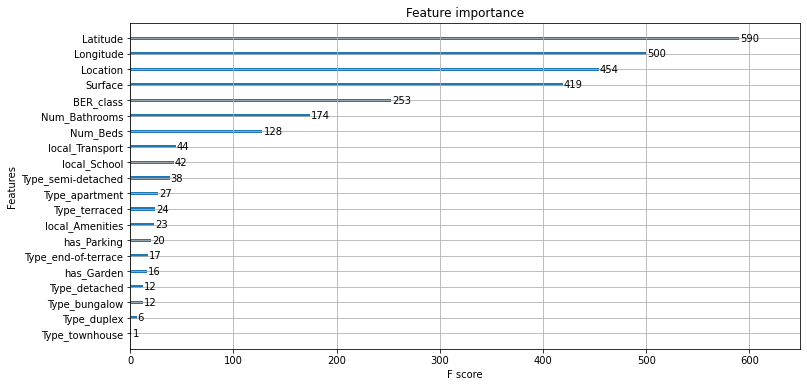

In [63]:
# Plot the Feature Importance to see what the impact of imputing BER_class has been
fig, ax = plt.subplots(figsize=(12, 6))

model_processed_data.get_booster().feature_names = features
xgb.plot_importance(model_processed_data, max_num_features= 21, ax=ax, importance_type="weight")
plt.show()

### **Analysis of new feature importance metrics**
From above plot it can be seen that the addition of the new features has impacted on the feature importance ranking. Most of the NLP features rank better than the 'Type' features, especially local_Transport, local_School, local_Amenities. These are interesting observations given that the features were embedded in text descriptions. The plot above has proven the value of NLP feature engineering, certainly in this case.

## Training, Validation & Test Data

In [64]:
# Reload the data to ensure we are working with clean datasets

path = '/content/sample_data/'

# Due to formatting issues, I found that explicitly defining features of interest and omitting ones that are problematic was useful

train_file = path+'HousePrice_Train.csv'
test_file = path+'HousePrice_Test.csv'

# Import the data, while excluding 'features' and 'description_block' explicitly on import
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

In [65]:
df_tr = drop_outliers(train_data)

In [66]:
# Separate the training dataset into Training and Validation Sets
colnames = list(df_tr.columns)
X = df_tr.iloc[:,0:-1].values 
y = df_tr.iloc[:,-1].values.reshape(-1,1)  

In [67]:
# Split training data into training and validation sets

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, shuffle = False)


In [68]:
# Convert numpy arrays to dataframes before processing

X_df_trn = pd.DataFrame(X_train, columns=colnames[:-1])
X_df_val = pd.DataFrame(X_val, columns=colnames[:-1])

In [69]:
# Execute preprocessing steps for each dataset
# First for training data
X_trn_step_1 = new_features(X_df_trn)
X_trn_ = process_dataset(X_trn_step_1, exclude="Type")
X_trn = X_trn_.values

# Next for validation data
X_val_step_1 = new_features(X_df_val)
X_val_ = process_dataset(X_val_step_1, exclude="Type")
X_val = X_val_.values

# Then for Test data
X_tst_step_1 = new_features(test_data)
X_tst_ = process_dataset(X_tst_step_1, exclude="Type")
X_tst = X_tst_.values


In [70]:
# Scale 'Price' if the dataset if Training

ylog = np.log(y_train.astype('float'))
yscaler = standardscaler.fit(ylog)
y_trn =  yscaler.transform(ylog)

### Train dataset

In [85]:
# show first data frame rows 
X_trn_.head(2)

,Location,Num_Bathrooms,Num_Beds,BER_class,Latitude,Longitude,Surface,has_Garden,has_Parking,local_School,local_Transport,local_Amenities
0,0.727891,0.693147,0.693147,-0.308404,0.620314,-2.004819,-0.803499,0,1,1,1,1
1,0.714286,0.000000,0.693147,0.030544,0.086969,0.194496,-0.109123,1,0,1,0,1


In [86]:
# Generate descriptive statistics
X_trn_.describe()

,Location,Num_Bathrooms,Num_Beds,BER_class,Latitude,Longitude,Surface,has_Garden,has_Parking,local_School,local_Transport,local_Amenities
count,1144.000000,1144.000000,1144.000000,1.144000e+03,1.144000e+03,1.144000e+03,1.144000e+03,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000
mean,0.493899,0.573604,1.014252,2.393191e-16,7.657526e-14,-2.101903e-15,-7.955951e-16,0.763112,0.687937,0.616259,0.701049,0.904720
std,0.291405,0.501227,0.417951,1.000437e+00,1.000437e+00,1.000437e+00,1.000437e+00,0.425359,0.463538,0.486509,0.457999,0.293729
min,0.000000,0.000000,0.000000,-3.019988e+00,-1.828771e+00,-2.648097e+00,-3.279863e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.244898,0.000000,0.693147,-6.473522e-01,-7.794919e-01,-5.569837e-01,-6.216262e-01,1.000000,0.000000,0.000000,0.000000,1.000000
50%,0.455782,0.693147,1.098612,3.054387e-02,-1.193644e-01,8.847636e-02,-1.085192e-01,1.000000,1.000000,1.000000,1.000000,1.000000
75%,0.782313,1.098612,1.386294,7.084399e-01,4.148042e-01,7.141824e-01,5.214280e-01,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,2.708050,2.708050,2.064232e+00,3.768460e+00,2.239625e+00,4.763999e+00,1.000000,1.000000,1.000000,1.000000,1.000000


### Validation dataset

In [87]:
X_val_.head(2)

,Location,Num_Bathrooms,Num_Beds,BER_class,Latitude,Longitude,Surface,has_Garden,has_Parking,local_School,local_Transport,local_Amenities
0,0.383562,1.94591,1.945910,0.729833,0.133894,-0.174115,1.176450,0,0,0,1,1
1,0.554795,0.00000,0.693147,0.376455,-0.125558,-0.652997,-0.907761,1,1,0,1,1


In [88]:
X_val_.describe()

,Location,Num_Bathrooms,Num_Beds,BER_class,Latitude,Longitude,Surface,has_Garden,has_Parking,local_School,local_Transport,local_Amenities
count,491.000000,491.000000,491.000000,4.910000e+02,4.910000e+02,4.910000e+02,4.910000e+02,491.000000,491.000000,491.000000,491.000000,491.000000
mean,0.516349,0.610902,1.051803,2.469172e-16,-1.483172e-13,4.284421e-15,-9.542039e-17,0.780041,0.714868,0.629328,0.712831,0.885947
std,0.292266,0.525939,0.446404,1.001020e+00,1.001020e+00,1.001020e+00,1.001020e+00,0.414641,0.451938,0.483477,0.452903,0.318200
min,0.000000,0.000000,0.000000,-2.803943e+00,-1.729079e+00,-2.450815e+00,-6.001987e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.256849,0.000000,0.693147,-6.836774e-01,-7.300245e-01,-6.142714e-01,-6.747513e-01,1.000000,0.000000,0.000000,0.000000,1.000000
50%,0.472603,0.693147,1.098612,2.307772e-02,-1.535161e-01,1.407822e-01,-1.015180e-01,1.000000,1.000000,1.000000,1.000000,1.000000
75%,0.801370,1.098612,1.386294,7.298328e-01,4.368323e-01,6.589140e-01,5.747842e-01,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,2.890372,3.295837,2.143343e+00,3.622611e+00,2.097493e+00,4.612305e+00,1.000000,1.000000,1.000000,1.000000,1.000000


### Test dataset

In [89]:
# show first data frame rows 
X_tst_.head(2)

,Location,Num_Bathrooms,Num_Beds,BER_class,Latitude,Longitude,Surface,has_Garden,has_Parking,local_School,local_Transport,local_Amenities
0,0.655172,0.693147,0.693147,-0.616615,-0.462275,0.098546,-0.854973,0,1,0,1,1
1,0.448276,0.693147,1.609438,0.689377,0.546564,-0.322551,0.571829,1,1,1,1,1


In [90]:
# Generate descriptive statistics
X_tst_.describe()

,Location,Num_Bathrooms,Num_Beds,BER_class,Latitude,Longitude,Surface,has_Garden,has_Parking,local_School,local_Transport,local_Amenities
count,702.000000,702.000000,702.000000,7.020000e+02,7.020000e+02,7.020000e+02,7.020000e+02,702.000000,702.000000,702.000000,702.000000,702.000000
mean,0.507663,0.580580,1.013545,-3.722885e-16,5.027555e-14,6.153356e-15,1.031147e-16,0.742165,0.688034,0.594017,0.692308,0.914530
std,0.291095,0.498537,0.415753,1.000713e+00,1.000713e+00,1.000713e+00,1.000713e+00,0.437754,0.463626,0.491431,0.461868,0.279779
min,0.000000,0.000000,0.000000,-2.575603e+00,-1.846362e+00,-2.936280e+00,-2.143177e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.270690,0.000000,0.693147,-6.166147e-01,-7.474966e-01,-5.664116e-01,-6.430413e-01,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.462069,0.693147,1.098612,3.638120e-02,-1.251458e-01,5.039519e-02,-8.309184e-02,1.000000,1.000000,1.000000,1.000000,1.000000
75%,0.793103,1.098612,1.386294,6.893772e-01,4.245285e-01,7.443558e-01,5.047100e-01,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,2.197225,2.639057,1.995369e+00,3.607425e+00,2.133195e+00,8.059505e+00,1.000000,1.000000,1.000000,1.000000,1.000000


### Baseline Predictions on Test with a Known Model Performance 
Let's set a baseline prediction on test data from XGBoost so we can compare with Bayesian Regression and Bayesian Neural Network

In [71]:
# Call XGBoost Model for each dataset
model_processed_data, RMSE_xgb_processed, r2_xgb_processed = xgb_model(X_trn, y_trn, "Performance Evaluation for Full Training Set with New Features")

Performance Evaluation for Full Training Set with New Features
RMSE_score: 0.0124   R2_score: 0.9998


In [72]:
# Predict on test dataset
y_pred_tst = model_processed_data.predict(X_tst)
y_pred_blr_tst = np.exp(yscaler.inverse_transform(y_pred_tst))

In [73]:
# Record baseline prices
df_prices = test_data['Index']
df_prices_tst = pd.DataFrame(y_pred_blr_tst, columns=['Baseline_price'])
full_test_predictions = pd.concat([df_prices, df_prices_tst], axis=1)
full_test_predictions

,Index,Baseline_price
0,1639,4.150231e+05
1,1640,5.011805e+05
2,1641,6.149604e+05
3,1642,1.305630e+06
4,1643,4.293751e+05
...,...,...
697,2336,2.236142e+05
698,2337,4.069345e+05
699,2338,5.456849e+05
700,2339,6.364734e+05


**Comment** These are the baseline predictions from XGBoost with a MAPE of 17% - we expect these to be a good estimate to check other methods against.

# PIECEWISE REGRESSION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

### Bayesian Model Price Prediction on dataset with all key features (excluding 'Type' as determined above in EDA Section

In [74]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=X_trn.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, X_trn.T)
    #likelihood, be sure that observed is a 1d vector
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=y_trn[:,0])

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Finished [100%]: Average Loss = 944.58


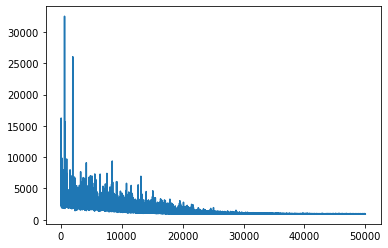

In [75]:
#number of iterations of the algorithms
iter = 50000

# run the model
with model:
    approximation = pm.fit(iter,method='advi')
    
# check the convergence
plt.plot(approximation.hist);

In [76]:
# samples from the posterior
posterior = approximation.sample(draws=702)

In [77]:
# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), X_tst.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
print(len(y_pred_BLR))

702


In [98]:
df_prices = full_test_predictions
df_prices_bayes_full = pd.DataFrame(y_pred_BLR, columns=['Bayes_full_price'])
full_test_predictions = pd.concat([full_test_predictions, df_prices_bayes_full], axis=1)
full_test_predictions

,Index,Baseline_price,Bayes_full_price
0,1639,4.150231e+05,322759.770161
1,1640,5.011805e+05,501242.978570
2,1641,6.149604e+05,530196.332540
3,1642,1.305630e+06,775982.885230
4,1643,4.293751e+05,447204.015396
...,...,...,...
697,2336,2.236142e+05,202256.411182
698,2337,4.069345e+05,250391.308633
699,2338,5.456849e+05,506232.910687
700,2339,6.364734e+05,598520.094601


In [99]:
mape_bayes_full = MAPE(y_pred_blr_tst, y_pred_BLR)

print("MAPE_validation: %.4f   MAPE_bayes_full: %.4f" %(mape_val, mape_bayes_full))

MAPE_validation: 0.1715   MAPE_bayes_full: 0.1920


**Comments** MAPE_bayes_full is the MAPE score when comparing the baseline estimated prices on the test dataset with the estimated prices from the Bayesian Regression Model with all key features. This score of 19.3 % is a good performance if we are confident that the baseline estimates are good enough. Given the performance of the baseline estimation using XGBoost, it is reasonable to take this view.

### Price Prediction using Piecewise Bayesian Model (Clustering by Top 2 Key Features)

In [100]:
X_trn_.columns

Index(['Location', 'Num_Bathrooms', 'Num_Beds', 'BER_class', 'Latitude',
       'Longitude', 'Surface', 'has_Garden', 'has_Parking', 'local_School',
       'local_Transport', 'local_Amenities'],
      dtype='object')

**Comment** from the Feature Importance analysis above, the Longitude and Latitude features rank the highest. We will look at these features for the Piecewise approach.

In [91]:
# clustering by features 4, 5; from list above these are 'longitude' and 'latitude'
ind=[4, 5]
X_ind = np.vstack([X_trn[:,ind],X_tst[:,ind]])

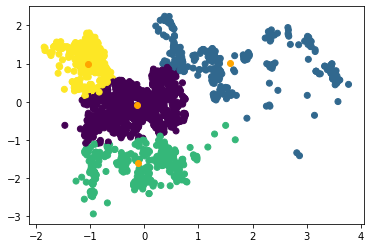

In [92]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4)

# Gaussian Mixture
gmm.fit(X_ind)
# plot predicted clusters
label = gmm.predict(X_ind)
plt.scatter(X_ind[:,0],X_ind[:,1], c = label)
# centroids:  orange dots
plt.scatter(gmm.means_[:,0],gmm.means_[:,1], c = 'orange')

**Comment** reviewing 3, 4, 5 and 6 clusters, four clusters seems a reasonable choice.

#### Prediction on 4 Clusters

This approach can be tricky due to the clustering of the test data, i.e. clustering will shuffle the order of test property samples. To ensure that we do not mix up predictions, we keep track of the Index value throughout the clustering steps and then add back the Index when the predictions are made. We can then re-oder the predictions to align with other predictions from above approaches. **Note** if we did not do this, the predictions are very poor and essentially meaningless.

In [93]:
# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, shuffle = False)

# Change names to make them more meaningful
X_train = X_trn
X_test = X_tst

In [94]:
# train clusters

clusters_train = gmm.predict(X_train[:,ind])
unique_train, counts_train = np.unique(clusters_train, return_counts=True)
dict(zip(unique_train, counts_train))

{0: 575, 1: 186, 2: 199, 3: 184}

In [95]:
# Add back in the Index for the test data so we can realign the values afterwards
# This is important because the clustering shuffles the values and there is no way to realign unless we know the Index value

index_arr = test_data['Index'].to_numpy()
new_test = np.insert(X_test, 0, index_arr, axis=1)

In [97]:
# Test clusters
clusters_test = gmm.predict(new_test[:,ind])
unique_test, counts_test = np.unique(clusters_test, return_counts=True)
dict(zip(unique_test, counts_test))

{0: 376, 1: 148, 2: 125, 3: 53}

In [110]:
# Process data for cluster 0
Xn0 = X_train[clusters_train==0,:]
Xtestn0 = new_test[clusters_test==0,:]
Xtestn0 = np.delete(Xtestn0, 0, axis=1) # drop Index from test data.

ylog0 = np.log(y_train.astype('float')[clusters_train==0,:])
yscaler0 = StandardScaler().fit(ylog0)
yn0 = yscaler0.transform(ylog0)

In [111]:
# Process data for cluster 1
Xn1 = X_train[clusters_train==1,:]
Xtestn1 = new_test[clusters_test==1,:]
Xtestn1 = np.delete(Xtestn1, 0, axis=1) # drop Index from test data.

ylog1 = np.log(y_train.astype('float')[clusters_train==1,:])
yscaler1 = StandardScaler().fit(ylog1)
yn1 = yscaler1.transform(ylog1)

In [112]:
# Process data for cluster 2
Xn2 = X_train[clusters_train==2,:]
Xtestn2 = new_test[clusters_test==2,:]
Xtestn2 = np.delete(Xtestn2, 0, axis=1) # drop Index from test data.

ylog2 = np.log(y_train.astype('float')[clusters_train==2,:])
yscaler2 = StandardScaler().fit(ylog2)
yn2 = yscaler2.transform(ylog2)

In [113]:
# Process data for cluster 3
Xn3 = X_train[clusters_train==3,:]
Xtestn3 = new_test[clusters_test==3,:]
Xtestn3 = np.delete(Xtestn3, 0, axis=1) # drop Index from test data.

ylog3 = np.log(y_train.astype('float')[clusters_train==3,:])
yscaler3 = StandardScaler().fit(ylog3)
yn3 = yscaler3.transform(ylog3)

In [114]:
# Train model_0
with pm.Model() as model_0:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn0.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn0.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn0[:,0])

with model_0:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior   
posterior0 = approximation.sample(counts_test[0])

Finished [100%]: Average Loss = 485.69


In [115]:
# Train model_1
with pm.Model() as model_1:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn1.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn1.T)
  # likelihood, # 
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn1[:,0])
  
with model_1:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior1 = approximation.sample(counts_test[1])

Finished [100%]: Average Loss = 199.99


In [116]:
# Train model_2
with pm.Model() as model_2:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn2.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  # linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn2.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn2[:,0])
    
with model_2:
  # iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior2 = approximation.sample(counts_test[2])

Finished [100%]: Average Loss = 216.02


In [117]:
# Train model_3
with pm.Model() as model3:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn3.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  mu = alpha + pm.math.dot(beta, Xn3.T)#linear regression model in matrix form
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn3[:,0])
    
with model3:
  # number of iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior     
posterior3 = approximation.sample(counts_test[3])

Finished [100%]: Average Loss = 220.91


In [118]:
# Posterior predictive checks (PPCs)
def ppc(alpha,beta,sigma, X,  nsamples=500):
    #we select nsamples random samples from the posterior
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        #we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T +np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
    return Ypred

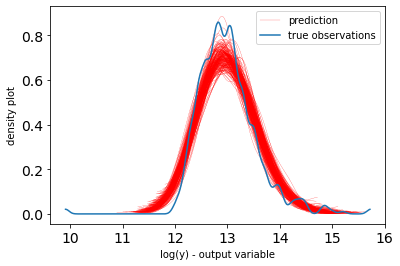

In [119]:
# Simulation for cluster 0
# Reverse the scaling for predicted value to get back to the original price scale
Ypred0 = yscaler0.inverse_transform(ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200))
for i in range(Ypred0.shape[0]):
    az.plot_dist( Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog0,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

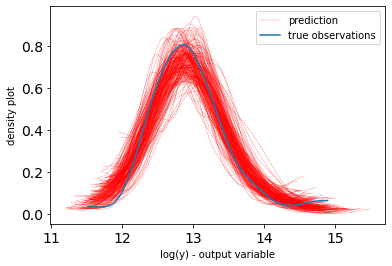

In [120]:
#Simulation for cluster 1
# Reverse the scaling for predicted value to get back to the original price scale
Ypred1 = yscaler1.inverse_transform(ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200))
for i in range(Ypred1.shape[0]):
    az.plot_dist( Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog1,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

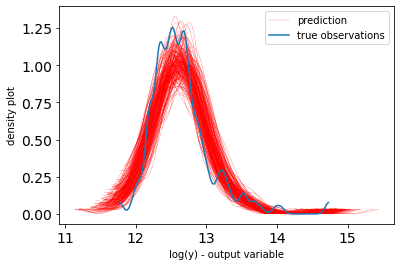

In [121]:
#Simulation
Ypred2 = yscaler2.inverse_transform(ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200))
for i in range(Ypred2.shape[0]):
    az.plot_dist( Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog2,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

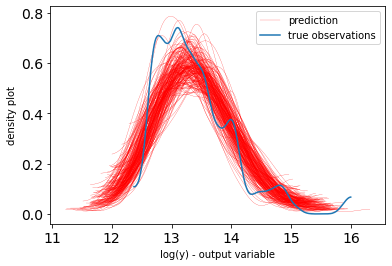

In [122]:
#Simulation for Cluster 3
# Reverse the scaling for predicted value to get back to the original price scale
Ypred3 = yscaler3.inverse_transform(ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200))
for i in range(Ypred3.shape[0]):
    az.plot_dist( Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog3,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

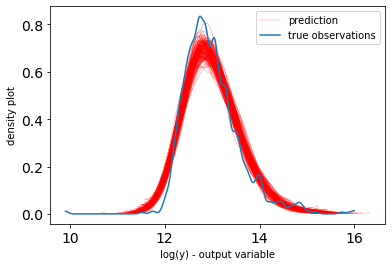

In [123]:
# Using PPC, take 200 samples from the posteriors of each cluster
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200)

# Create a combined predicted value by reversing the scaling done on each cluster prediction
Ypred = np.hstack([ yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3)])

# Plot the distribution for the combined set of samples
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})

# plot the predicted distributions against the true distribution to see how they are close
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
ylog=np.vstack([ylog0,ylog1,ylog2,ylog3])
az.plot_dist(ylog,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

In [125]:
# cluster 0
y_pred_BLR0 = np.exp(yscaler0.inverse_transform(np.mean(posterior0['alpha']) 
              + np.dot(np.mean(posterior0['beta'],axis=0), Xtestn0.T)))

# cluster 1
y_pred_BLR1 = np.exp(yscaler1.inverse_transform(np.mean(posterior1['alpha']) 
              + np.dot(np.mean(posterior1['beta'],axis=0), Xtestn1.T)))

# cluster 2
y_pred_BLR2 = np.exp(yscaler2.inverse_transform(np.mean(posterior2['alpha']) 
              + np.dot(np.mean(posterior2['beta'],axis=0), Xtestn2.T)))

# cluster 3
y_pred_BLR3 = np.exp(yscaler3.inverse_transform(np.mean(posterior3['alpha']) 
              + np.dot(np.mean(posterior3['beta'],axis=0), Xtestn3.T)))

In [163]:
# Add back in the relevant indices ('Index' column)for each clusters before joining the clusters

# Cluster 0
idx_cluster0 = new_test[clusters_test==0,:1]
idx_cluster0 = np.reshape(idx_cluster0, len(y_pred_BLR0))
y_pred_BLR0 = np.dstack((idx_cluster0, y_pred_BLR0))

# Cluster 1
idx_cluster1 = new_test[clusters_test==1,:1]
idx_cluster1 = np.reshape(idx_cluster1, len(y_pred_BLR1))
y_pred_BLR1 = np.dstack((idx_cluster1, y_pred_BLR1))

# Cluster 2
idx_cluster2 = new_test[clusters_test==2,:1]
idx_cluster2 = np.reshape(idx_cluster2, len(y_pred_BLR2))
y_pred_BLR2 = np.dstack((idx_cluster2, y_pred_BLR2))

# Cluster 2
idx_cluster3 = new_test[clusters_test==3,:1]
idx_cluster3 = np.reshape(idx_cluster3, len(y_pred_BLR3))
y_pred_BLR3 = np.dstack((idx_cluster3, y_pred_BLR3))

In [178]:
joint_y_pred=np.hstack([y_pred_BLR0, y_pred_BLR1, y_pred_BLR2, y_pred_BLR3])
joint_y_pred = joint_y_pred.reshape((-1, 2)) # reshape to remove extraneous dimension in array
joint_y_pred = joint_y_pred[joint_y_pred[:,0].argsort()] # use sorted indexes to sort data columns in order of index value
joint_y_pred_values = joint_y_pred[:,1] # remove extraneous dimension

In [180]:
# Save predictions to predictions dataframe
df_1 = full_test_predictions
df_2 = pd.DataFrame(joint_y_pred_values, columns=['Price_Piecewise'])
full_test_predictions = pd.concat([df_1, df_2], axis=1)
full_test_predictions

,Index,Baseline_price,Price_Piecewise
0,1639,4.150231e+05,403557.808203
1,1640,5.011805e+05,466556.105237
2,1641,6.149604e+05,351471.425293
3,1642,1.305630e+06,843346.236841
4,1643,4.293751e+05,390202.000254
...,...,...,...
697,2336,2.236142e+05,192244.199039
698,2337,4.069345e+05,267923.491091
699,2338,5.456849e+05,394942.010511
700,2339,6.364734e+05,709439.692705


In [181]:
mape_bayes_cluster = MAPE(y_pred_blr_tst, joint_y_pred_values)

print("MAPE_validation: %.4f   MAPE_bayes_cluster: %.4f" %(mape_val, mape_bayes_cluster))

MAPE_validation: 0.1715   MAPE_bayes_cluster: 0.2744


**Comments** MAPE_bayes_cluster is the MAPE score when comparing the baseline estimated prices on the test dataset with the estimated prices from the Bayesian Piecewise Regression Model with all key features. This score of 27.4 % is reasonable for the method and is attributed to the use of only 2 features, where the other key feature also have a strong impact on performance of predictions. If the model was trained in clusters of all features, we would likely see a small improvement over just unclustered features.

Key challenge for this approach is to keep track of Index values for each cluster. Clusters do not contain sequential values but a mix depending on how the cluster algorithm selected the values for each cluster. The approach taken was:

- Re-insert the index in the Test Dataset before separating clusters

- Separate the data into clusters and drop the Index before training and testing each cluster - maintain the 'shape' of the index values for each cluster

- Follow predictions by each cluster, re-insert the relevant Index values for each cluster

- Because these are not ordered, we have to sort the data again by Index value after combining each cluster prediction

- Once the predictions are sorted by index, we can now compare these with previous results and calculate the MAPE value.

If we did not do this, we would get mis-aligned prediction values and the MAPE value would be meaningless.

# BAYESIAN NN

A [Bayesian network](https://en.wikipedia.org/wiki/Bayesian_network) (also known as a Bayes network, Bayes net, belief network, or decision network) is a probabilistic graphical model that represents a set of variables and their conditional dependencies via a directed acyclic graph (DAG). 

* Bayesian networks are ideal for taking an event that occurred and predicting the likelihood that any one of several possible known causes was the contributing factor. 
* For example, a Bayesian network could represent the probabilistic relationships between diseases and symptoms. 
* Given symptoms, the network can be used to compute the probabilities of the presence of various diseases.

It was expected that this approach would perform the best of all above approaches. However, it was challenging and time-consuming tuning hyperparameters for this model. With more time, a GridSearch approach may have worked better, but the calculation times of each step made this too long to be effective. With manual changes, I got small improvements. However, it is a factor in Neural Network performance tuning that the steps require careful testing and more time.

Even so, the Bayesian Neural Networks did not perform well and in fact was the worst of all approaches. With further research I will look to see if traditional approaches such as XGBoost perform better than Bayesian methods on such challenges. A key take-away was it has been seen that Bayesian methods are more challenging to work with and tune that other methods encountered.

In [189]:
# Instantiate Kernel
kernel = GPy.kern.RBF(input_dim=1,lengthscale=0.15,variance=0.2)
print(kernel)

  rbf.         |  value  |  constraints  |  priors
  variance     |    0.2  |      +ve      |        
  lengthscale  |   0.15  |      +ve      |        


In [192]:
# Split training data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, shuffle = False)

# Change names to make them more meaningful
X_train = X_trn
X_test = X_tst

In [193]:
# Scale 'Price' if the dataset if Training

ylog = np.log(y_train.astype('float'))
yscaler = standardscaler.fit(ylog)
y_train =  yscaler.transform(ylog)

In [194]:
# https://theano-pymc.readthedocs.io/en/latest/
import theano

# add a column of ones to include an intercept in the model
x1 = np.hstack([np.ones((X_train.shape[0],1)), X_train])
floatX = theano.config.floatX

In [195]:
l = 15
# Initialize random weights between each layer
# we do that to help the numerical algorithm that computes the posterior
init_1 = np.random.randn(x1.shape[1], l).astype(floatX)
init_out = np.random.randn(l).astype(floatX)

# pymc3 model as neural_network
with pm.Model() as bayesian_neural_network:
    # we convert the data in theano type so we can do dot products with the correct type.
    ann_input = pm.Data('ann_input', x1)
    ann_output = pm.Data('ann_output', y_train)
    # Priors 
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_1', 0, sigma=1,
                             shape=(x1.shape[1], l), testval=init_1)
    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_0', 0, sigma=1,
                              shape=(l,),testval=init_out)

    # Build neural-network using tanh activation function
    # Inner layer
    act_1 = pm.math.tanh(pm.math.dot(ann_input,weights_in_1))
    # Linear layer, like in Linear regression
    act_out = pm.Deterministic('act_out',pm.math.dot(act_1, weights_2_out))

    # standard deviation of noise
    sigma = pm.HalfCauchy('sigma',5)

    # Normal likelihood
    out = pm.Normal('out',
                       act_out,
                       sigma=sigma,
                       observed=ann_output[:,0])

In [187]:
par_1 = 100
par_2 = 1000

with bayesian_neural_network:
  posterior = pm.sample(par_1, tune=par_2, chains=1)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, w_0, w_1]


Sampling 1 chain for 945 tune and 0 draw iterations (945 + 0 draws total) took 586 seconds.
No posterior samples. Unable to run convergence checks


In [196]:
# we can do instead an approximated inference
param3 = 20000 # start with 1000, then use 50000+
VI = 'advi'  # 'advi', 'fullrank_advi', 'svgd', 'asvgd', 'nfvi'
OP = pm.adam # pm.adam, pm.sgd, pm.adagrad, pm.adagrad_window, pm.adadelta
LR = 0.001    

with bayesian_neural_network:
    approx = pm.fit(param3, method=VI, obj_optimizer=pm.adam(learning_rate=LR))

Finished [100%]: Average Loss = 1,016.2


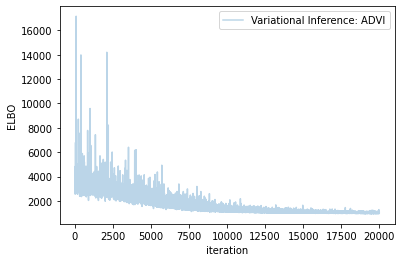

In [197]:
# plot 
pb.plot(approx.hist, label='Variational Inference: '+ VI.upper(), alpha=.3)
pb.legend(loc='upper right')
# Evidence Lower Bound (ELBO)
# https://en.wikipedia.org/wiki/Evidence_lower_bound
pb.ylabel('ELBO')
pb.xlabel('iteration');

In [198]:
# draw samples from variational posterior
D = 702
posterior = approx.sample(draws=D)

In [199]:
# add a column of ones to include an intercept in the model
x2 = np.hstack([np.ones((X_test.shape[0],1)), X_test])

y_pred = []
for i in range(posterior['w_1'].shape[0]):
    #inner layer
    t1 = np.tanh(np.dot(posterior['w_1'][i,:,:].T,x2.T))
    #outer layer
    y_pred.append(np.dot(posterior['w_0'][i,:],t1))

# predictions   
y_pred = np.array(y_pred)

**Comments** MAPE_BNN is the MAPE score when comparing the baseline estimated prices on the test dataset with the estimated prices from the Bayesian Neural Network Model with all key features. This score of 38.4% is not great performance. The model requires tuning. Results:

1) No tuning = 38.4%

2) Learning rate 0.001 = 36.0%

3) Learning_rate 0.0001 = 37.8% 

4) Addition of NUTS Sampler = 37.1%

Recommend, if time permits, a GridSearch approach to hyperparameter tuning.

In [201]:
# Save this file as a CSV

full_test_predictions.to_csv(path+'ET5003_Kaggle_RobertBarrett_20157347.csv')

# SUMMARY

The following is a table of predictions of test samples using Full Bayesian, Piecewise Bayesian and Bayesian Neural Network. The MAPE values for each of these are:

1. Baseline Price (XGBoost Regression) = 17%

2. Bayesian Full Regression = 19%

3. Bayesian Piecewise Regressian = 27%

4. Bayesian Neural Network = 36% (best)

In [200]:
# prediction
y_pred_BNN = np.exp(yscaler.inverse_transform(y_pred))[:,0]

# Let's check how close these are to the Full Mdel Predictions (Piecewise Approach)
df_1 = full_test_predictions.copy()
df_2 = pd.DataFrame(y_pred_BNN, columns=['Price_NN'])
full_test_predictions = pd.concat([df_1, df_2], axis=1)
full_test_predictions

,Index,Baseline_price,Price_Piecewise,Price_NN
0,1639,4.150231e+05,403557.808203,349969.256252
1,1640,5.011805e+05,466556.105237,311198.913927
2,1641,6.149604e+05,351471.425293,410136.616953
3,1642,1.305630e+06,843346.236841,343906.004843
4,1643,4.293751e+05,390202.000254,412120.800051
...,...,...,...,...
697,2336,2.236142e+05,192244.199039,394801.905287
698,2337,4.069345e+05,267923.491091,380135.607604
699,2338,5.456849e+05,394942.010511,290175.957445
700,2339,6.364734e+05,709439.692705,344608.932536


Data preprocessing was extensive with the application of feature exclusion, feature scaling and imputation. BER_class was a key feature and it required considerable analysis to impute the 15% missing values. I took the approach to get the mean of the BER values *by location* with the logic being that districts of Dublin are *in general* of the same level of maturity, i.e. proportion of new and old houses are the same within a district, acknowledging the districts can have new developments but less in more mature areas. This approahc worked well and imputation of values seemed not to affect overall performance when compared with XGBoost (which works well with missing values).

The addition of new features using NLP was also explored and followed the work described by Bird et al (2009) and Silge and Robinson (2021). I implemented an approach using word counting and TF-IDF to identify the key words within the sample text. In addition to using heuristics based on domain knowledge, 5 additional features were verified using word count and TF-IDF data. Checking these with Feature Importance ranking using XGBoost again showed that these features were important and more so than the one-hot-encoded 'Type' feature. Features added from NLP checked for availability of schools, public transport, parking, amenities (shops and pharmacy) and  garden.

Exploring each approach, and in the absence of test predictor values (Kaggle was not available to me for much of the assignment), I generated test predictor (y) values using XGBoost that performed well on Training and Validation data. I used this baseline to get a sense of how well the Bayesian methods were performing.

A key challeng was keeping the predictions from the Piecewise approach aligned through trainig and prediction. I did this by tracking the order of indexes once clustered and then reshaping and re-ordering the combined preidtion set at the end. This was important as clustering mixed up the data as described above.

Lastly, the Bayesian Neural Network approach was challenging to tune without deeper investigation of tuning parameters using 'gridsearch'. Results were disappointing but getting an introduction to this method helped broader my understanding of methods.


**References**

Bird, S. et al. (2009) *Natural language processing with Python* . 1st edition. Sebastopol, California: O’Reilly.


Gianfagna, L. & Di Cecco, A. (2021) *Explainable AI with Python.* Cham: Springer International Publishing AG.


Masís, S. (2021) *Interpretable Machine Learning with Python* [online], Packt, available: https://www.packtpub.com/product/interpretable-machine-learning-with-python/9781800203907 [accessed 12 October 2021].
